In [1]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/requirements.txt

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 1.4 MB/s eta 0:00:01
   - -------------------------------------- 0.0/1.1 MB 1.4 MB/s eta 0:00:01
   - -------------------------------------- 0.0/1.1 MB 1.4 MB/s eta 0:00:01
   - -------------------------------------- 0.0/1.1 MB 1.4 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.1 MB 302.7 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.1 MB 306.3 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.1 MB 347.8 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.1 MB 347.8 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.1 MB 347.8 kB/s eta 0:00:03
   ---- ----------------------------------- 0.1/1.1 MB 327.7 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.1 MB 339.1 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.1 MB 339.1 kB/s eta 0:00:03
   

In [2]:
#Import the packages needed.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

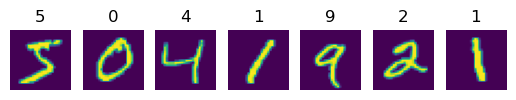

In [4]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

In [5]:
print('train data: ', len(data_train))
print('test data', len(data_test))
print(data_train[0][0].size())
print([data_test[i][1] for i in range(10)])

train data:  60000
test data 10000
torch.Size([1, 28, 28])
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [6]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


In [18]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2024-05-10 14:14:23--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: 'pytorchcv.py'

     0K ......                                                100% 12.5M=0s

2024-05-10 14:14:24 (12.5 MB/s) - 'pytorchcv.py' saved [6540/6540]



In [7]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, plot_results
load_mnist()

In [8]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

In [9]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64)

In [11]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.00527104237874349, 0.9099333333333334)

In [12]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005947186660766601, 0.899)

In [13]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.893, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


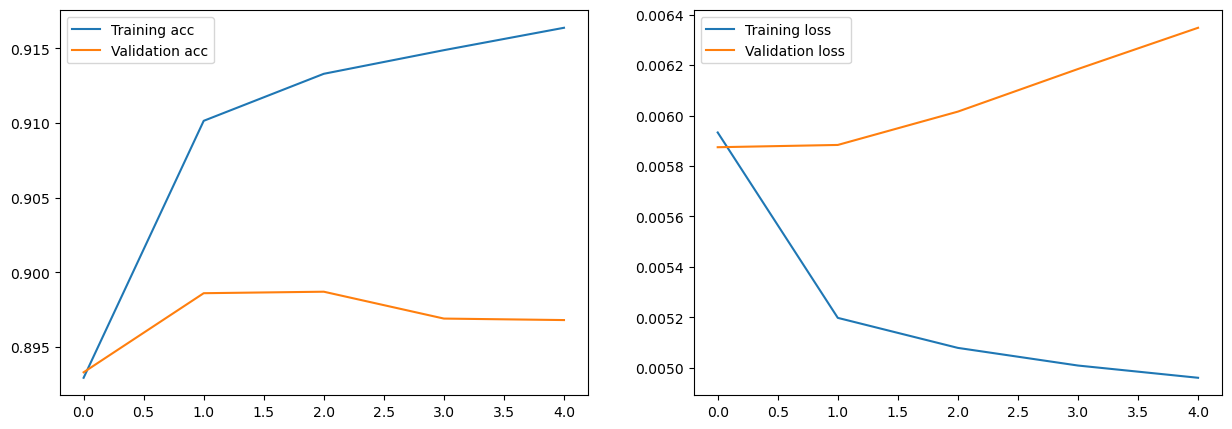

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

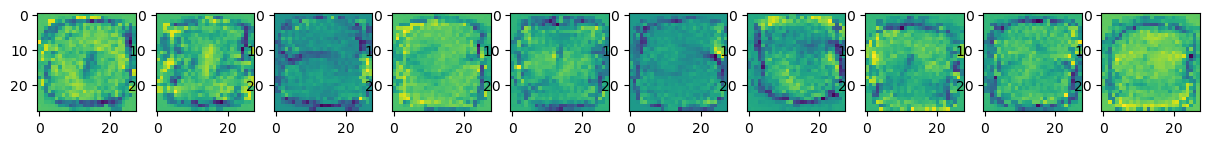

In [18]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

In [23]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

### Another syntax to perform same operation:

In [24]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net,input_size=(1,28,28),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Epoch  0, Train acc=0.927, Val acc=0.943, Train loss=0.035, Val loss=0.034
Epoch  1, Train acc=0.953, Val acc=0.952, Train loss=0.033, Val loss=0.034
Epoch  2, Train acc=0.958, Val acc=0.952, Train loss=0.033, Val loss=0.034
Epoch  3, Train acc=0.959, Val acc=0.956, Train loss=0.033, Val loss=0.033
Epoch  4, Train acc=0.963, Val acc=0.957, Train loss=0.033, Val loss=0.033


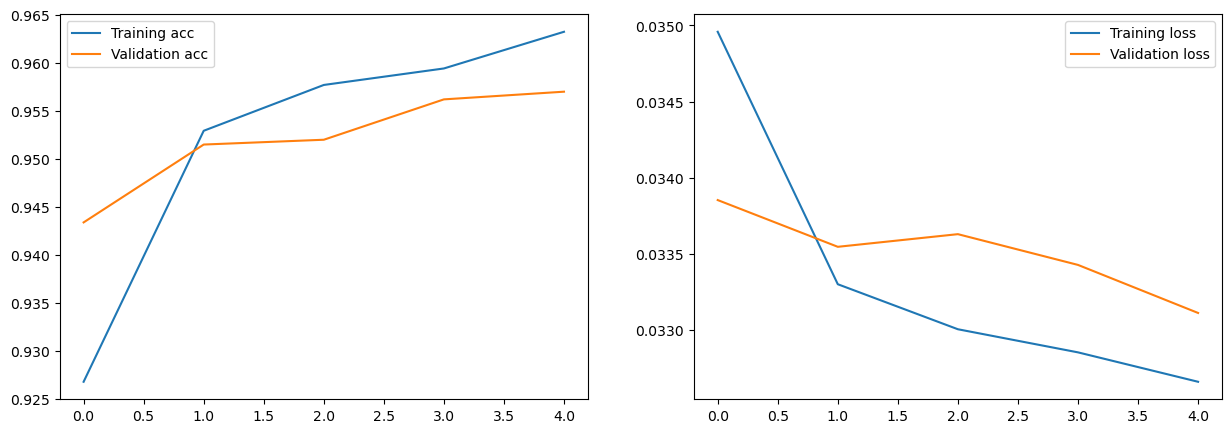

In [25]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)